In [1]:
import numpy as np
import bayespy as bp
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import cm
from matplotlib import colors
import scipy.stats
import os
import json
from tqdm import tqdm_notebook
import multiprocessing
import functools as ft
from sklearn.metrics import normalized_mutual_info_score
import importlib
import time_series
importlib.reload(time_series)
from time_series import *

%matplotlib inline
style.use('../figures/scrartcl.mplstyle')

In [2]:
hyperparameters = os.environ.get('HYPERPARAMETERS')
if hyperparameters:
    with open(hyperparameters) as fp:
        hyperparameters = json.load(fp)
else:
    hyperparameters = {
        'rho/concentration': 1e-3,
        'Lambda/shape': 0.0,     # We will add on the dimensionality of the space
        'Lambda/scale': 0.1,  # We will multiply by the identity matrix and the dimension
        'tau/shape': 1e-3,
        'tau/scale': 1e-3,
        'lambda/shape': 1e-5,
        'lambda/scale': 1e-5,
        'ard_prior': 'independent',
        'num_factors': [2, 6],
        'seed': list(range(50)),
        'tolerance': 1e-6,
        'initialization': 'kmeans',
        'num_groups': 5,
        'num_nodes': 50,
        'num_obs_fraction': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6],
        'p_missing': 0,
        'concentration': 1000,
        'inter_scale': 1.0
    }
    
print(json.dumps(hyperparameters, indent=4))

{
    "rho/concentration": 0.001,
    "Lambda/shape": 0.0,
    "Lambda/scale": 0.1,
    "tau/shape": 0.001,
    "tau/scale": 0.001,
    "lambda/shape": 1e-05,
    "lambda/scale": 1e-05,
    "ard_prior": "independent",
    "num_factors": [
        2,
        6
    ],
    "seed": [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
        35,
        36,
        37,
        38,
        39,
        40,
        41,
        42,
        43,
        44,
        45,
        46,
        47,
        48,
        49
    ],
    "tolerance": 1e-06,
    "initialization": "kmeans",
    "num_groups": 5,
    "num_nodes": 50,
    "num_obs_fraction": [

In [3]:
def simulate(hyperparameters, **kwargs):
    hyperparameters = hyperparameters.copy()
    hyperparameters.update(**kwargs)
    np.random.seed(hyperparameters['seed'])
    num_groups = hyperparameters['num_groups']
    num_factors = hyperparameters['num_factors']
    num_nodes = hyperparameters['num_nodes']
    num_obs = int(hyperparameters['num_obs_fraction'] * num_nodes)
    mu = np.random.normal(0, hyperparameters['inter_scale'], (num_groups, num_factors))
    # Lambda = scipy.stats.wishart.rvs(10, np.eye(num_factors), num_groups)
    Lambda = 10 * np.eye(num_factors) * np.ones((num_groups, 1, 1))
    rho = np.random.dirichlet(hyperparameters['concentration'] * np.ones(num_groups))
    idx = np.random.choice(num_groups, num_nodes, p=rho)
    z = np.zeros((num_nodes, num_groups))
    z[np.arange(num_nodes), idx] = 1
    A = mu[idx] + np.einsum('ijk,ik->ij', np.linalg.cholesky(np.linalg.inv(Lambda))[idx], 
                            np.random.normal(0, 1, (num_nodes, num_factors)))
    x = np.random.normal(0, 1, (num_obs, num_factors))
    predictor = np.dot(x, A.T)
    tau = np.random.gamma(100, 1 / 10, num_nodes)
    y = predictor + np.random.normal(0, 1 / np.sqrt(tau), (num_obs, num_nodes))
    y[np.random.uniform(size=y.shape) < hyperparameters['p_missing']] = np.nan

    return locals()

# Recovering the number of factors

# Recovering the number of groups

In [222]:
variables2, list_params2 = build_parameters(hyperparameters, 'num_obs_fraction', 'seed', num_factors=2, num_groups=10)
shape2 = [len(v) for v in variables2.values()]
simulations2 = [simulate(params, num_groups=5) for params in list_params2]
variables2

OrderedDict([('num_obs_fraction',
              [0.1,
               0.2,
               0.3,
               0.4,
               0.5,
               0.6,
               0.7,
               0.8,
               0.9,
               1.0,
               1.2,
               1.4,
               1.6]),
             ('seed',
              [2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19])])

In [193]:
def target2(args):
    simulation, params = args
    return fit_model(simulation['y'], params)


with multiprocessing.Pool() as pool:
    models2 = list(tqdm_notebook(pool.imap(target2, zip(simulations2, list_params2)), total=len(list_params2)))

95/|/ 41%|| 95/234 [10:10<14:52,  6.42s/it]


In [194]:
nmis = []
num_actual_groups = []
num_expected_groups = []
for Q, simulation in zip(models2, simulations2):
    actual = np.argmax(Q['z'].get_moments()[0], axis=1)
    expected = simulation['idx']
    nmis.append(normalized_mutual_info_score(expected, actual))
    num_actual_groups.append(len(set(actual)))
    num_expected_groups.append(len(set(expected)))
    
nmis = np.reshape(nmis, shape2)
num_actual_groups = np.reshape(num_actual_groups, shape2)

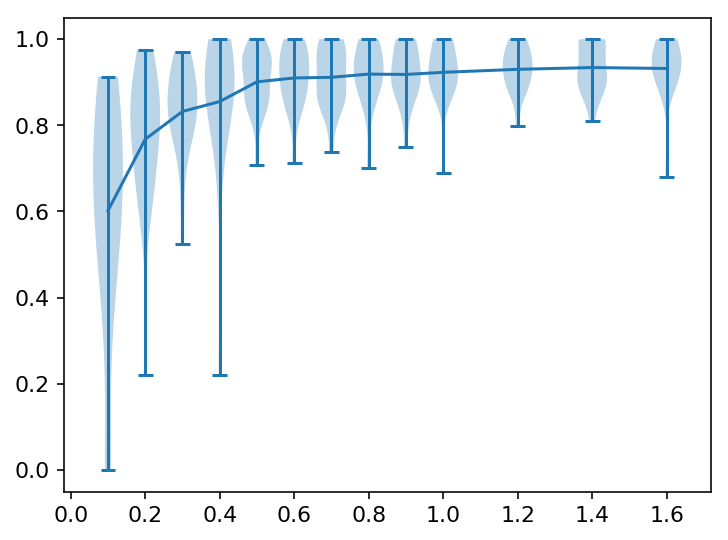

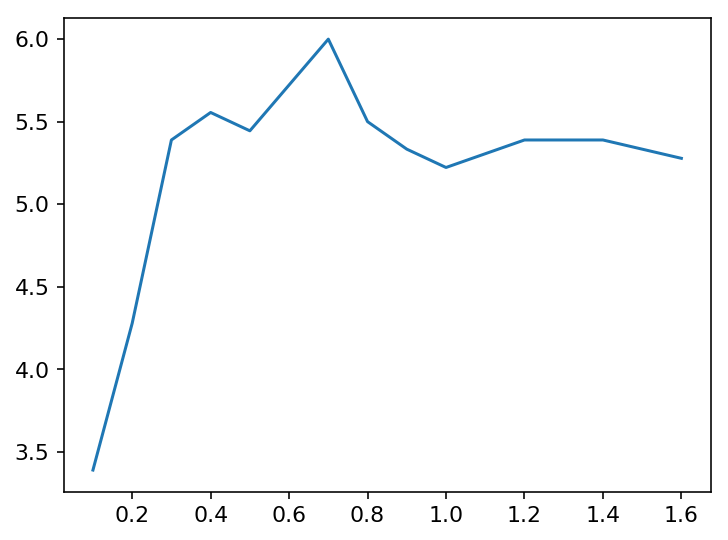

In [195]:
plt.violinplot(nmis.T, positions=variables['num_obs_fraction'], widths=0.08)
plt.plot(variables['num_obs_fraction'], np.mean(nmis, axis=1), color='C0')
plt.figure()
plt.plot(variables['num_obs_fraction'], np.mean(num_actual_groups, axis=1))

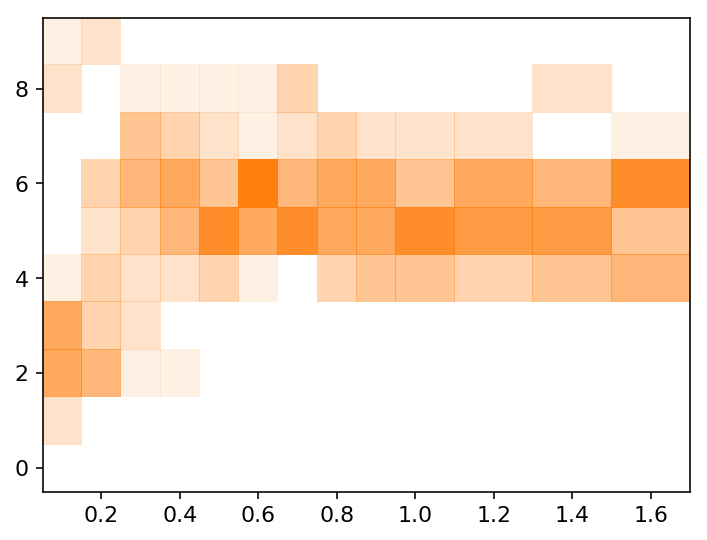

In [196]:
y = np.asarray([np.bincount(x, minlength=np.max(num_actual_groups + 1)) for x in num_actual_groups])
plt.pcolormesh(pcolorcoords(hyperparameters['num_obs_fraction']), pcolorcoords(np.arange(y.shape[1])), y.T,
               cmap=cmap)

# Separation of Gaussians

In [248]:
variables3, list_params3 = build_parameters(
    hyperparameters, 'inter_scale', 'seed', num_factors=2, num_groups=10, num_obs_fraction=1,
    inter_scale=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
)
shape3 = [len(v) for v in variables3.values()]
simulations3 = [simulate(params, num_groups=5) for params in list_params3]
variables3

OrderedDict([('inter_scale', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]),
             ('seed',
              [2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19])])

In [249]:
def target3(args):
    simulation, params = args
    return fit_model(simulation['y'], params)


with multiprocessing.Pool() as pool:
    models3 = list(tqdm_notebook(pool.imap(target3, zip(simulations3, list_params3)), total=len(list_params3)))

In [250]:
nmis2 = []
num_actual_groups2 = []

for Q, simulation in zip(models3, simulations3):
    actual = np.argmax(Q['z'].get_moments()[0], axis=1)
    expected = simulation['idx']
    nmis2.append(normalized_mutual_info_score(expected, actual))
    num_actual_groups2.append(len(set(actual)))
    
nmis2 = np.reshape(nmis2, shape3)
num_actual_groups2 = np.reshape(num_actual_groups2, shape3)

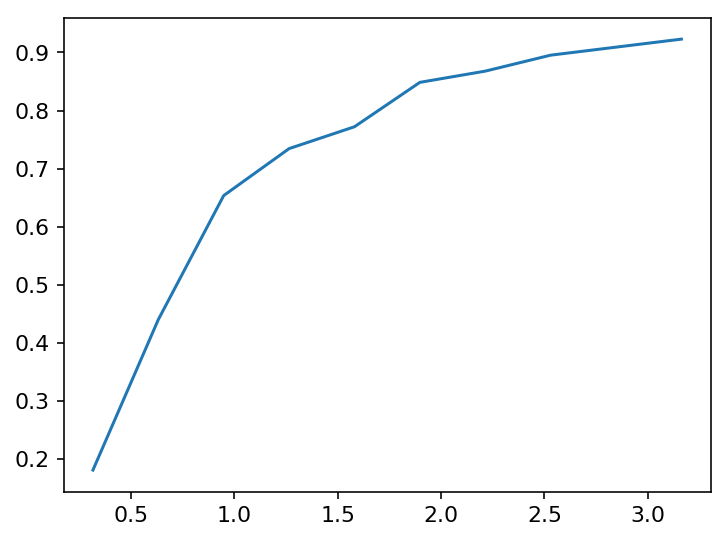

In [251]:
plt.plot(np.asarray(, nmis2.mean(axis=1))

# Final figure

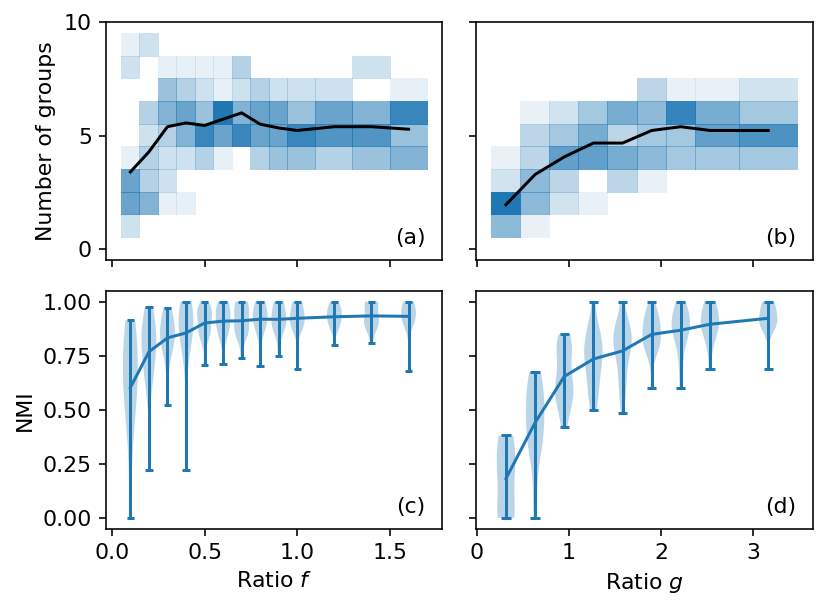

In [261]:
fig, axes = plt.subplots(2, 2, sharey='row', sharex='col')

color1 = colors.to_rgba('C0')
color2 = np.copy(color1)
color2[3] = 0
cmap = colors.LinearSegmentedColormap.from_list('linear', [color2, color1])

ax = axes[0, 0]
ax.yaxis.major.locator._integer = True

y = np.asarray([np.bincount(x, minlength=np.max(num_actual_groups + 1)) for x in num_actual_groups])
ax.pcolormesh(pcolorcoords(hyperparameters['num_obs_fraction']), pcolorcoords(np.arange(y.shape[1])), y.T,
              cmap=cmap)
ax.plot(hyperparameters['num_obs_fraction'], np.mean(num_actual_groups, axis=1), color='k')
ax.set_ylabel('Number of groups')

ax = axes[0, 1]

ratio = np.asarray(variables3['inter_scale']) / np.sqrt(0.1)
y = np.asarray([np.bincount(x, minlength=np.max(num_actual_groups2 + 1)) for x in num_actual_groups2])
ax.pcolormesh(pcolorcoords(ratio), pcolorcoords(np.arange(y.shape[1])), y.T,
              cmap=cmap)
ax.plot(ratio, np.mean(num_actual_groups2, axis=1), color='k')

ax = axes[1, 0]

ax.violinplot(nmis.T, positions=variables['num_obs_fraction'], widths=0.08)
ax.plot(variables['num_obs_fraction'], np.mean(nmis, axis=1), color='C0')
ax.set_ylabel('NMI')
ax.set_xlabel('Ratio $f$')

ax = axes[1, 1]

ax.violinplot(nmis2.T, positions=ratio, widths=0.2)
ax.plot(ratio, np.mean(nmis2, axis=1), color='C0')
ax.set_xlabel('Ratio $g$')

label_axes(axes, x=0.95, ha='right', y=0.05, va='bottom')

fig.tight_layout()

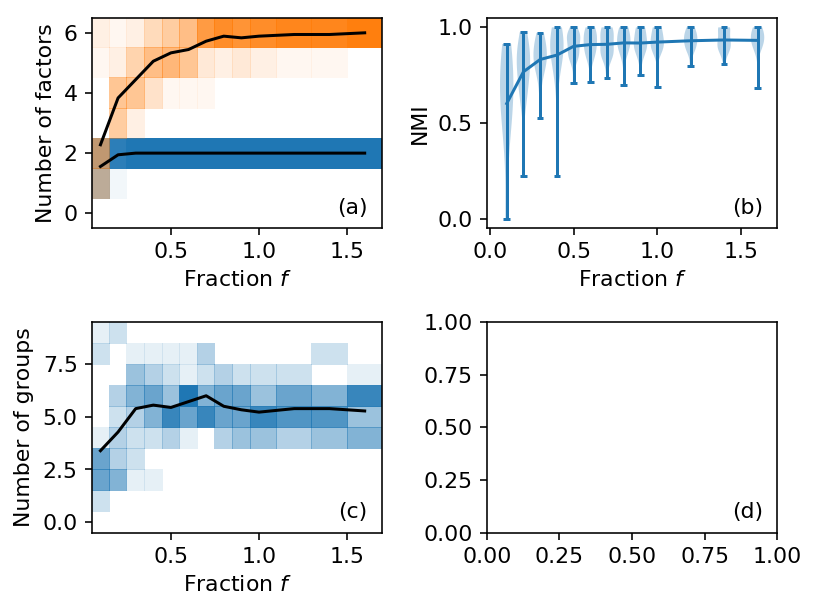

In [214]:
fig, axes = plt.subplots(2, 2)

ax = axes[0, 0]
for i, num_factors in enumerate(variables['num_factors']):
    color = 'C%d' % i
    color1 = colors.to_rgba(color)
    color2 = np.copy(color1)
    color2[3] = 0
    cmap = colors.LinearSegmentedColormap.from_list('linear', [color2, color1])

    y = np.asarray([np.bincount(x, minlength=np.max(best_num_factors[i] + 1)) for x in best_num_factors[i]])
    ax.pcolormesh(pcolorcoords(hyperparameters['num_obs_fraction']), pcolorcoords(np.arange(y.shape[1])), y.T,
                   cmap=cmap)    
    ax.plot(hyperparameters['num_obs_fraction'], np.mean(best_num_factors[i], axis=1), color='k')
    # plt.axhline(num_factors, color='w', ls='--')
    
ax.set_xlabel('Fraction $f$')
ax.set_ylabel('Number of factors')

ax = axes[0, 1]

ax.violinplot(nmis.T, positions=variables['num_obs_fraction'], widths=0.08)
ax.plot(variables['num_obs_fraction'], np.mean(nmis, axis=1), color='C0')
ax.set_ylabel('NMI')
ax.set_xlabel('Fraction $f$')

ax = axes[1, 0]

color1 = colors.to_rgba('C0')
color2 = np.copy(color1)
color2[3] = 0
cmap = colors.LinearSegmentedColormap.from_list('linear', [color2, color1])
y = np.asarray([np.bincount(x, minlength=np.max(num_actual_groups + 1)) for x in num_actual_groups])
ax.pcolormesh(pcolorcoords(hyperparameters['num_obs_fraction']), pcolorcoords(np.arange(y.shape[1])), y.T,
              cmap=cmap)
ax.plot(hyperparameters['num_obs_fraction'], np.mean(num_actual_groups, axis=1), color='k')
ax.set_xlabel('Fraction $f$')
ax.set_ylabel('Number of groups')

label_axes(axes, x=0.95, ha='right', y=0.05, va='bottom')

fig.tight_layout()

# Heatmap of NMI

In [4]:
hyperparameters

{'Lambda/scale': 0.1,
 'Lambda/shape': 0.0,
 'ard_prior': 'independent',
 'concentration': 1000,
 'initialization': 'kmeans',
 'inter_scale': 1.0,
 'lambda/scale': 1e-05,
 'lambda/shape': 1e-05,
 'num_factors': [2, 6],
 'num_groups': 5,
 'num_nodes': 50,
 'num_obs_fraction': [0.1,
  0.2,
  0.3,
  0.4,
  0.5,
  0.6,
  0.7,
  0.8,
  0.9,
  1.0,
  1.2,
  1.4,
  1.6],
 'p_missing': 0,
 'rho/concentration': 0.001,
 'seed': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 'tau/scale': 0.001,
 'tau/shape': 0.001,
 'tolerance': 1e-06}

In [5]:
params = hyperparameters.copy()
params['Lambda/scale'] = [0.05, 0.1, 0.4, 0.8, 1.6]

variables_hm, list_params_hm = build_parameters(
    params, 'num_obs_fraction', 'inter_scale', 'seed', 'Lambda/scale',
    num_obs_fraction=[0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
    inter_scale=[0.25, 0.5, 1, 2, 4, 8, 16],
    seed = list(range(50)),
    num_factors=2
)
for i, params in enumerate(list_params_hm):
    params['seed'] = i
simulations_hm = [simulate(params) for params in list_params_hm]
shape_hm = [len(v) for v in variables_hm.values()]
shape_hm

[11, 7, 50, 5]

In [67]:
# Use a simpler commnity detection algorithm
import community
import networkx as nx

simple_nmis = []
simple_num_groups = []

for simulation in tqdm_notebook(simulations_hm):
    if simulation['y'].shape[0] > 2:
        cov = np.cov(simulation['y'].T, bias=True)
        var = np.diag(cov).copy()
        var[var == 0] = 1
        corr = cov / np.sqrt(var[:, None] * var[None, :])

        adjacency = (corr + 1) / 2
        adjacency[np.diag_indices_from(adjacency)] = 0
        graph = nx.from_numpy_array(adjacency)

        dendrogram = community.generate_dendrogram(graph, resolution=1)
        best_delta = 100
        for level in range(len(dendrogram)):
            partition = community.partition_at_level(dendrogram, level)
            delta = abs(simulation['num_groups'] - len(set(partition.values())))
            if delta < best_delta:
                best_score = sklearn.metrics.mutual_info_score(simulation['idx'], [partition[i] for i in range(len(partition))])
                n = len(set(partition.values()))
    else:
        best_score = np.nan
        n = np.nan
    
    simple_nmis.append(best_score)
    simple_num_groups.append(n)
    
simple_nmis = np.reshape(simple_nmis, shape_hm)
simple_num_groups = np.reshape(simple_num_groups, shape_hm)

HBox(children=(IntProgress(value=0, max=19250), HTML(value='')))

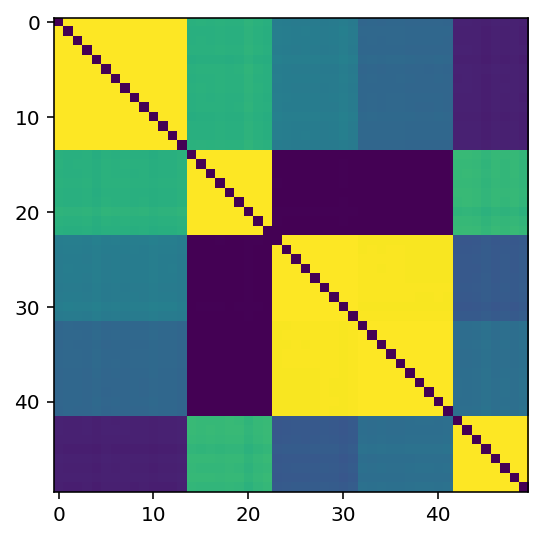

In [79]:
plt.imshow(adjacency[np.argsort(simulation['idx'])][:, np.argsort(simulation['idx'])], vmax=1, vmin=0)

In [75]:
len(community.generate_dendrogram(graph, resolution=10))

1

In [72]:
np.max(simple_num_groups, axis=(2, 3))

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.],
       [  3.,   3.,   3.,   3.,   3.,   3.,   3.]])

/Users/till/miniconda3/envs/time_series/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median for 14 results
  r = func(a, **kwargs)
/Users/till/miniconda3/envs/time_series/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


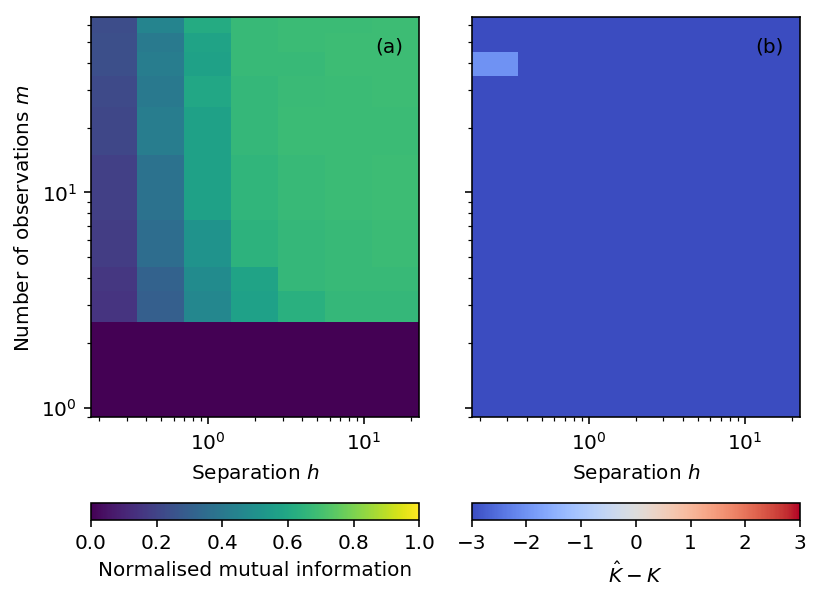

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, True, True)

ax = ax1
f = np.asarray(variables_hm['num_obs_fraction']) * hyperparameters['num_nodes']
g = variables_hm['inter_scale']
# plt.imshow(np.mean(nmis, axis=2), vmin=0, vmax=1)
mappable = ax.pcolormesh(pcolorcoords(g, 'log'), pcolorcoords(f), np.median(simple_nmis, axis=(2, 3)), vmin=0, vmax=1)
# cs = ax.contour(g, f, np.mean(nmis, axis=-1), [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='w')
# plt.clabel(cs, fmt='%1.1f')
ax.set_xscale('log')
ax.set_ylabel('Number of observations $m$')
ax.set_xlabel('Separation $h$')
cb = plt.colorbar(mappable, ax=ax, orientation='horizontal')
cb.set_label('Normalised mutual information')

ax = ax2
delta = np.median(simple_num_groups, axis=(2, 3)) - hyperparameters['num_groups']
# delta = scipy.stats.mode(num_actual_groups[i, j, k, l], axis=-1).mode[..., 0] - hyperparameters['num_groups']
vmax = np.max(np.abs(delta[np.isfinite(delta)]))
mappable = ax.pcolormesh(pcolorcoords(g, 'log'), pcolorcoords(f), delta, vmax=vmax, vmin=-vmax, cmap='coolwarm')
ax.set_xlabel('Separation $h$')
cb = plt.colorbar(mappable, ax=ax, orientation='horizontal')
cb.set_label(r'$\hat K - K$')

label_axes((ax1, ax2), x=0.95, ha='right')

ax.set_yscale('log')
ax.set_ylim(bottom=0.9)

fig.tight_layout()

In [24]:
def target_hm(args):
    simulation, params = args
    params = params.copy()
    params['num_groups'] = 10
    params['tolerance'] = 1e-4
    return fit_model(simulation['y'], params)


with multiprocessing.Pool() as pool:
    models_hm = list(tqdm_notebook(pool.imap(target_hm, zip(simulations_hm, list_params_hm)), total=len(list_params_hm)))

108/|/  1%|| 108/7700 [00:28<33:17,  3.80it/s]


In [25]:
nmis = []
num_actual_groups = []
lowerbounds = []

for Q, simulation in zip(models_hm, simulations_hm):
    actual = np.argmax(Q['z'].get_moments()[0], axis=1)
    expected = simulation['idx']
    nmis.append(normalized_mutual_info_score(expected, actual))
    num_actual_groups.append(len(set(actual)))
    lowerbounds.append(Q.compute_lowerbound())
    
nmis = np.reshape(nmis, shape_hm)
num_actual_groups = np.reshape(num_actual_groups, shape_hm)
lowerbounds = np.reshape(lowerbounds, shape_hm)

In [28]:
l = np.argmax(lowerbounds, axis=3)
i, j, k = np.indices(shape_hm[:-1])
nmis[i,j,k,l].shape

NameError: name 'lowerbounds' is not defined

In [27]:
import scipy.stats

In [28]:
nmis.shape

(11, 7, 50, 5)

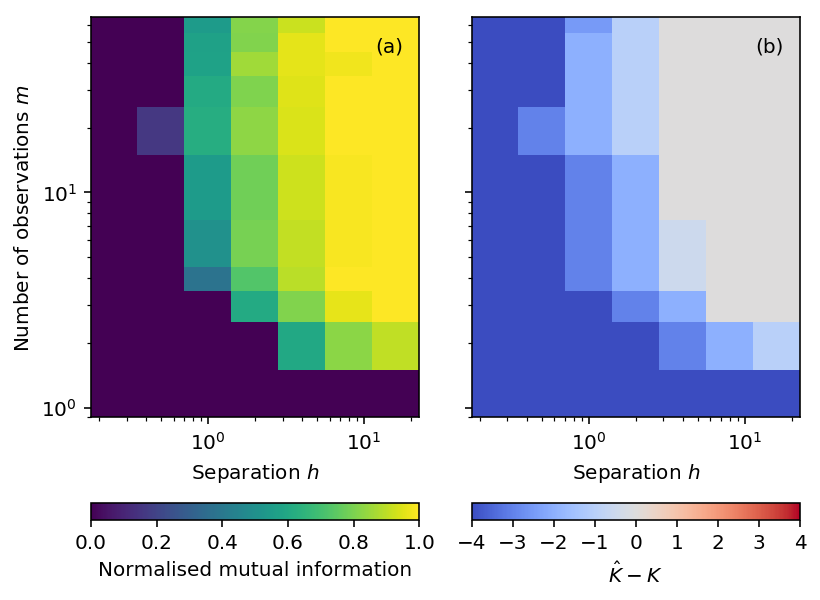

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, True, True)

ax = ax1
f = np.asarray(variables_hm['num_obs_fraction']) * hyperparameters['num_nodes']
g = variables_hm['inter_scale']
# plt.imshow(np.mean(nmis, axis=2), vmin=0, vmax=1)
mappable = ax.pcolormesh(pcolorcoords(g, 'log'), pcolorcoords(f), np.median(nmis[i, j, k, l], axis=-1), vmin=0, vmax=1)
# cs = ax.contour(g, f, np.mean(nmis, axis=-1), [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], colors='w')
# plt.clabel(cs, fmt='%1.1f')
ax.set_xscale('log')
ax.set_ylabel('Number of observations $m$')
ax.set_xlabel('Separation $h$')
cb = plt.colorbar(mappable, ax=ax, orientation='horizontal')
cb.set_label('Normalised mutual information')

ax = ax2
delta = np.median(num_actual_groups[i, j, k, l], axis=-1) - hyperparameters['num_groups']
# delta = scipy.stats.mode(num_actual_groups[i, j, k, l], axis=-1).mode[..., 0] - hyperparameters['num_groups']
vmax = np.max(np.abs(delta))
mappable = ax.pcolormesh(pcolorcoords(g, 'log'), pcolorcoords(f), delta, vmax=vmax, vmin=-vmax, cmap='coolwarm')
ax.set_xlabel('Separation $h$')
cb = plt.colorbar(mappable, ax=ax, orientation='horizontal')
cb.set_label(r'$\hat K - K$')

label_axes((ax1, ax2), x=0.95, ha='right')

ax.set_yscale('log')
ax.set_ylim(bottom=0.9)

fig.tight_layout()
fig.savefig('../figures/sensitivity.pdf')
fig.savefig('../figures/sensitivity.png')

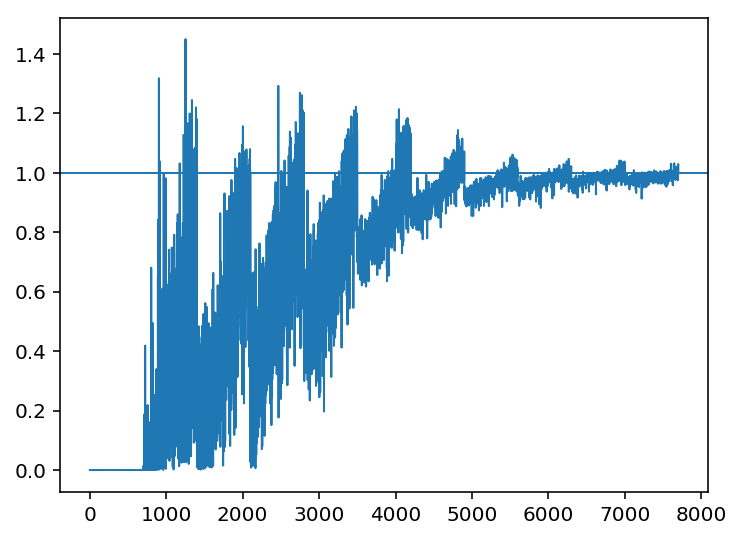

In [102]:
plt.plot([q['x'].get_moments()[0].std(axis=0).mean() for q, s in zip(models_hm.ravel(), simulations_hm.ravel())])
plt.axhline(1)

TypeError: Invalid dimensions for image data

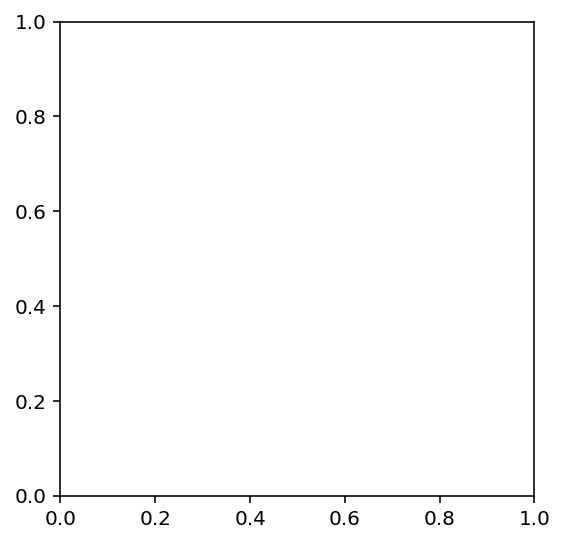

In [103]:
std = [np.sqrt(np.square(s['A'] - s['mu'][s['idx']]).mean()) 
          for q, s in zip(models_hm.ravel(), simulations_hm.ravel())]
std = np.reshape(std, shape_hm)

plt.imshow(std.mean(axis=2), origin='lower')
plt.colorbar()
std.shape

(11, 7, 20)

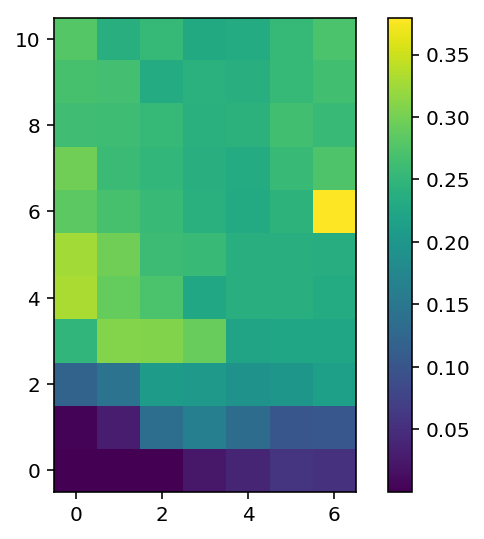

In [53]:
std = [np.sqrt(np.square(q['A'].get_moments()[0] - q['mu'].get_moments()[0][np.argmax(q['z'].get_moments()[0], axis=1)]).mean()) 
          for q, s in zip(models_hm.ravel(), simulations_hm.ravel())]
std = np.reshape(std, shape_hm)

plt.imshow(std.mean(axis=2), origin='lower')
plt.colorbar()
std.shape

In [250]:
list(map(count_communities, models_hm[0, 3]))

[4, 4, 6, 8, 6, 7, 6, 7, 5, 6]

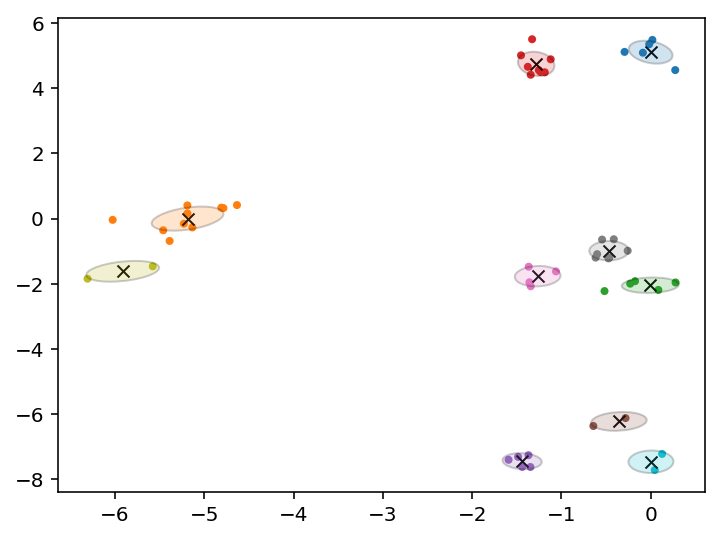

In [114]:
plot_mixture(models_hm[0, 3, 3])

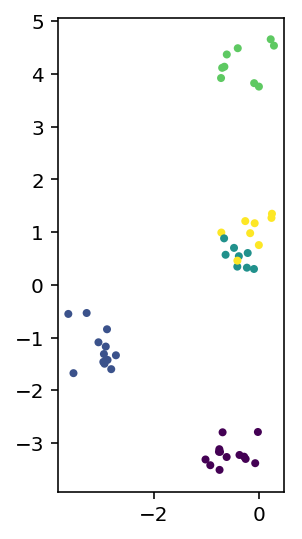

In [259]:
s = simulations_hm[0, 3, 3]
p = list_params_hm[0, 3, 3]
plt.scatter(*s['A'].T, c=s['idx'])
plt.gca().set_aspect(1)

In [289]:
import time_series
importlib.reload(time_series)
from time_series import *

In [294]:
p = p.copy()
p['Lambda/scale'] = 1
p['tolerance'] = 1e-4
_Q = fit_model(s['y'], p, verbose=True, initialization='kmeans', seed=2, 
               num_groups=10, steps=(0, 1, 2, 3))

created model in 0.005
fitted embedding in 0.248
lowerbound: -841.776006
created community model in 0.007
lowerbound: -1000820.780296
initialized kmeans in 0.047
fitted GMM in 0.053
lowerbound: -985.222892


In [295]:
vals = []
for i in range(100):
    _Q.update(verbose=False)
    vals.append(_Q['z'].get_moments()[0])

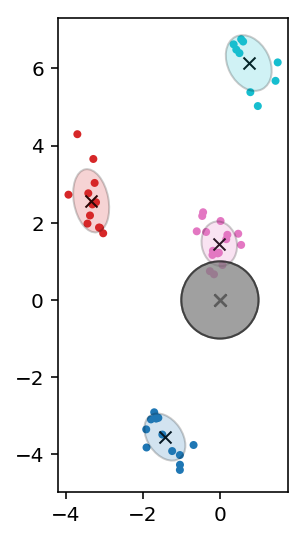

In [275]:
plot_mixture(_Q, plot_empty=True)
plt.gca().set_aspect(1)

array([[ 0.8688542 ,  0.98869356]])

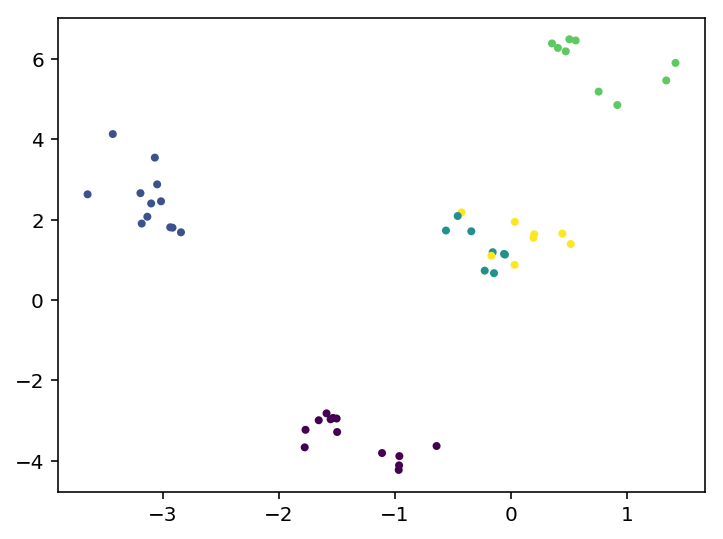

In [254]:
plt.scatter(*_Q['A'].get_moments()[0].T, c=s['idx'])
_Q['x'].get_moments()[0].std(axis=0)

In [261]:
residuals = s['A'] - s['mu'][s['idx']]
np.mean(residuals ** 2)

0.091117760780297707

In [264]:
_Q['Lambda'].get_moments()[0]

array([[[ 14.78526773,  -2.76858153],
        [ -2.76858153,  13.26657165]],

       [[ 15.36966691,  -7.38060459],
        [ -7.38060459,  12.01482743]],

       [[ 25.01620118,  -0.87674749],
        [ -0.87674749,  20.02579625]],

       [[ 10.        ,   0.        ],
        [  0.        ,  10.        ]],

       [[ 24.61381592,  -4.13793041],
        [ -4.13793041,  11.69736382]],

       [[ 10.0085864 ,  -4.86102106],
        [ -4.86102106,   8.12420101]],

       [[  9.90223818,   4.05710957],
        [  4.05710957,   8.65939219]],

       [[ 11.60502663,  -0.24939269],
        [ -0.24939269,  13.53674363]],

       [[ 10.        ,   0.        ],
        [  0.        ,  10.        ]],

       [[ 12.8573474 ,   5.12360936],
        [  5.12360936,   7.56562509]]])

In [262]:
s['Lambda']

array([[[ 10.,   0.],
        [  0.,  10.]],

       [[ 10.,   0.],
        [  0.,  10.]],

       [[ 10.,   0.],
        [  0.,  10.]],

       [[ 10.,   0.],
        [  0.,  10.]],

       [[ 10.,   0.],
        [  0.,  10.]]])